In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
from glob import glob
import skimage.io as io
import shutil

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\rattunet\sessile-main-Kvasir-SEG


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG"
print(os.listdir(data_dir))

['masks', 'images']


In [5]:
img_dir = data_dir + "/images"
msk_dir = data_dir + "/masks"

print(f"No. Img: {len(os.listdir(img_dir))}")
print(f"No. Msk: {len(os.listdir(msk_dir))}")

No. Img: 196
No. Msk: 196


In [6]:
class PolypDataset(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(img_dir + "/*"))
        self.msks = sorted(glob(msk_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

ds = PolypDataset(transform=transform, target_transform=target_transform)
train_ds, test_ds = random_split(ds, [0.8, 0.2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


157


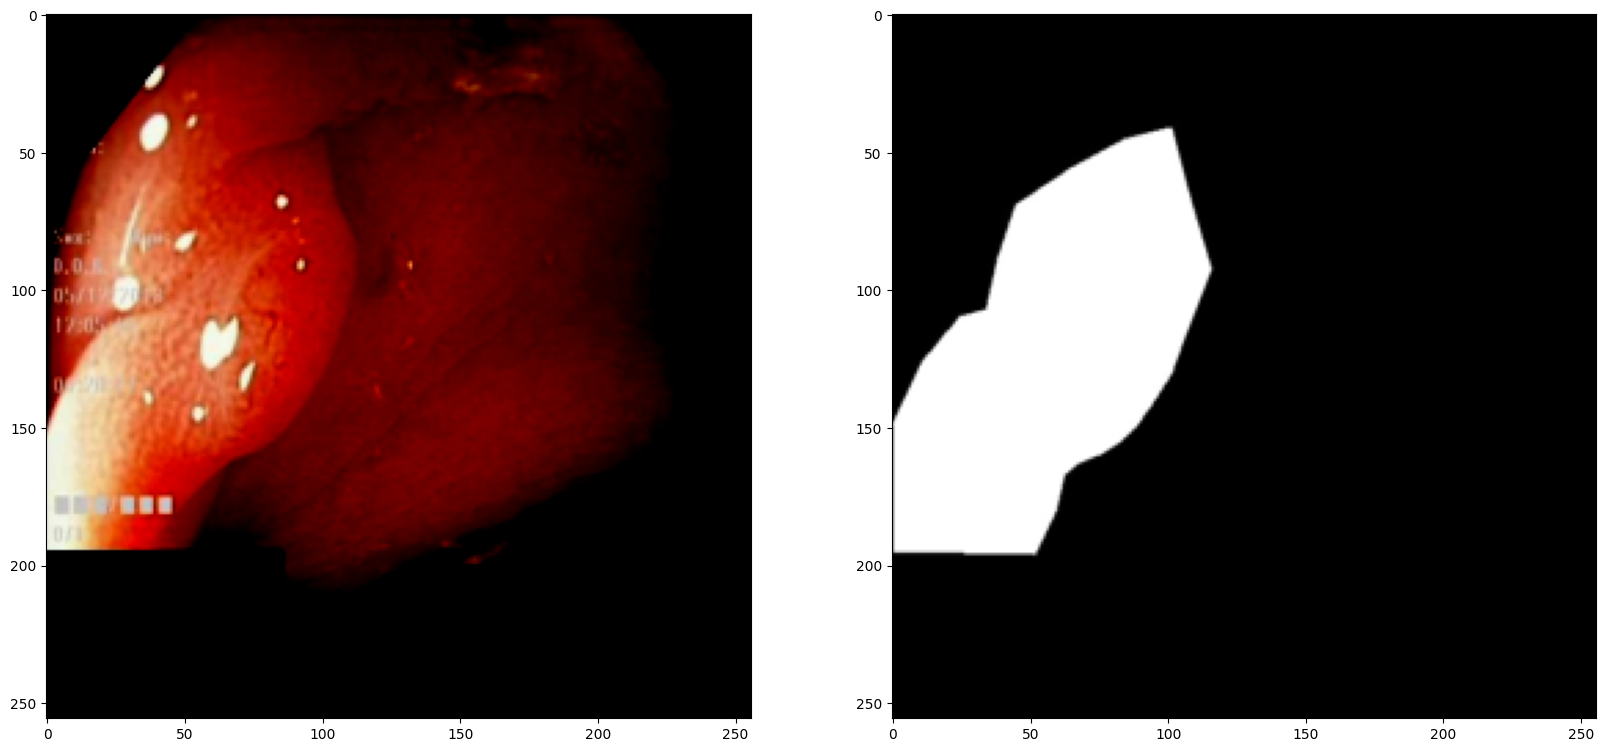

In [8]:
print(len(train_ds))

img, msk = train_ds[25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [9]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

8


In [10]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [11]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = 0
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [12]:
class R2AttU_Net(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, t=2, init_channels = 16):
        super(R2AttU_Net, self).__init__()

        n1 = init_channels
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.RRCNN1 = RRCNN_block(in_ch, filters[0], t=t)
        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)
        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)
        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)
        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        e4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        e3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        e2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        e1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

        return out

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = R2AttU_Net(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [14]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch: 0 - TrainLoss: 0.6643284261226654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.50it/s]


Epoch: 1 - TrainLoss: 0.5670805871486664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.08it/s]


Epoch: 2 - TrainLoss: 0.4886297695338726


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch: 3 - TrainLoss: 0.4153646267950535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch: 4 - TrainLoss: 0.3554079085588455


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.25it/s]


Epoch: 5 - TrainLoss: 0.30786117166280746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.60it/s]


Epoch: 6 - TrainLoss: 0.27273716032505035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.50it/s]


Epoch: 7 - TrainLoss: 0.25198021717369556


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


Epoch: 8 - TrainLoss: 0.23790638148784637


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Epoch: 9 - TrainLoss: 0.23453046008944511


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.66it/s]


Epoch: 10 - TrainLoss: 0.22768578492105007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Epoch: 11 - TrainLoss: 0.22775092720985413


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch: 12 - TrainLoss: 0.22236236557364464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch: 13 - TrainLoss: 0.22474347241222858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Epoch: 14 - TrainLoss: 0.22198412381112576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.96it/s]


Epoch: 15 - TrainLoss: 0.22201289981603622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Epoch: 16 - TrainLoss: 0.220651401206851


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.91it/s]


Epoch: 17 - TrainLoss: 0.21866639703512192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.75it/s]


Epoch: 18 - TrainLoss: 0.2217586785554886


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Epoch: 19 - TrainLoss: 0.22282050363719463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.87it/s]


Epoch: 20 - TrainLoss: 0.22402297891676426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Epoch: 21 - TrainLoss: 0.22335379756987095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.79it/s]


Epoch: 22 - TrainLoss: 0.22018211521208286


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch: 23 - TrainLoss: 0.21748910285532475


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Epoch: 24 - TrainLoss: 0.21607032045722008


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Epoch: 25 - TrainLoss: 0.21447225846350193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch: 26 - TrainLoss: 0.2157559935003519


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.59it/s]


Epoch: 27 - TrainLoss: 0.21633952856063843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch: 28 - TrainLoss: 0.21883919462561607


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Epoch: 29 - TrainLoss: 0.2161051668226719


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch: 30 - TrainLoss: 0.21657446399331093


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.20it/s]


Epoch: 31 - TrainLoss: 0.21170270442962646


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.51it/s]


Epoch: 32 - TrainLoss: 0.21295838244259357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


Epoch: 33 - TrainLoss: 0.21306771039962769


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


Epoch: 34 - TrainLoss: 0.21428298950195312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch: 35 - TrainLoss: 0.2112714983522892


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


Epoch: 36 - TrainLoss: 0.2126014605164528


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Epoch: 37 - TrainLoss: 0.20955839566886425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.84it/s]


Epoch: 38 - TrainLoss: 0.20966606587171555


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.91it/s]


Epoch: 39 - TrainLoss: 0.2082388922572136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.70it/s]


Epoch: 40 - TrainLoss: 0.20761713571846485


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch: 41 - TrainLoss: 0.20752722583711147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Epoch: 42 - TrainLoss: 0.20666959881782532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch: 43 - TrainLoss: 0.20572163723409176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch: 44 - TrainLoss: 0.20786354318261147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch: 45 - TrainLoss: 0.20629863813519478


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Epoch: 46 - TrainLoss: 0.20157871022820473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch: 47 - TrainLoss: 0.20076346583664417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Epoch: 48 - TrainLoss: 0.20084361545741558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch: 49 - TrainLoss: 0.20639851316809654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]


Epoch: 50 - TrainLoss: 0.2042114995419979


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


Epoch: 51 - TrainLoss: 0.20495876297354698


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch: 52 - TrainLoss: 0.19868008978664875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch: 53 - TrainLoss: 0.19609864242374897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch: 54 - TrainLoss: 0.2029495369642973


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


Epoch: 55 - TrainLoss: 0.2032911702990532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Epoch: 56 - TrainLoss: 0.19647502712905407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch: 57 - TrainLoss: 0.19626744650304317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Epoch: 58 - TrainLoss: 0.19136281684041023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Epoch: 59 - TrainLoss: 0.2012489065527916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.87it/s]


Epoch: 60 - TrainLoss: 0.19426503218710423


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Epoch: 61 - TrainLoss: 0.19230232201516628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Epoch: 62 - TrainLoss: 0.1889510191977024


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Epoch: 63 - TrainLoss: 0.19344793446362019


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch: 64 - TrainLoss: 0.19143217243254185


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.83it/s]


Epoch: 65 - TrainLoss: 0.190118458122015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.73it/s]


Epoch: 66 - TrainLoss: 0.19167225435376167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch: 67 - TrainLoss: 0.18801167979836464


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.06it/s]


Epoch: 68 - TrainLoss: 0.19071537256240845


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]


Epoch: 69 - TrainLoss: 0.18601147457957268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Epoch: 70 - TrainLoss: 0.18758457526564598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Epoch: 71 - TrainLoss: 0.1849843394011259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


Epoch: 72 - TrainLoss: 0.18786289915442467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.74it/s]


Epoch: 73 - TrainLoss: 0.19519785232841969


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.57it/s]


Epoch: 74 - TrainLoss: 0.18109535984694958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


Epoch: 75 - TrainLoss: 0.17916768603026867


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch: 76 - TrainLoss: 0.18861626088619232


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.30it/s]


Epoch: 77 - TrainLoss: 0.1906684897840023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.62it/s]


Epoch: 78 - TrainLoss: 0.17666553147137165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch: 79 - TrainLoss: 0.1866725254803896


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.62it/s]


Epoch: 80 - TrainLoss: 0.19181321375072002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.53it/s]


Epoch: 81 - TrainLoss: 0.1884136889129877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.47it/s]


Epoch: 82 - TrainLoss: 0.18669286370277405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch: 83 - TrainLoss: 0.18728209659457207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch: 84 - TrainLoss: 0.1807238906621933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.42it/s]


Epoch: 85 - TrainLoss: 0.17714008130133152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.44it/s]


Epoch: 86 - TrainLoss: 0.18122962210327387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.49it/s]


Epoch: 87 - TrainLoss: 0.17970510572195053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.36it/s]


Epoch: 88 - TrainLoss: 0.17694294080138206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


Epoch: 89 - TrainLoss: 0.17816056497395039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.49it/s]


Epoch: 90 - TrainLoss: 0.17201019451022148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.44it/s]


Epoch: 91 - TrainLoss: 0.1753934258595109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch: 92 - TrainLoss: 0.1771400310099125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.18it/s]


Epoch: 93 - TrainLoss: 0.18072085455060005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.57it/s]


Epoch: 94 - TrainLoss: 0.1723430510610342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.48it/s]


Epoch: 95 - TrainLoss: 0.17598450183868408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.37it/s]


Epoch: 96 - TrainLoss: 0.17515244707465172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.39it/s]


Epoch: 97 - TrainLoss: 0.1672546025365591


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.50it/s]


Epoch: 98 - TrainLoss: 0.16414626501500607


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.57it/s]

Epoch: 99 - TrainLoss: 0.16807535849511623


<All keys matched successfully>

In [15]:
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print(len(test_dl))

39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


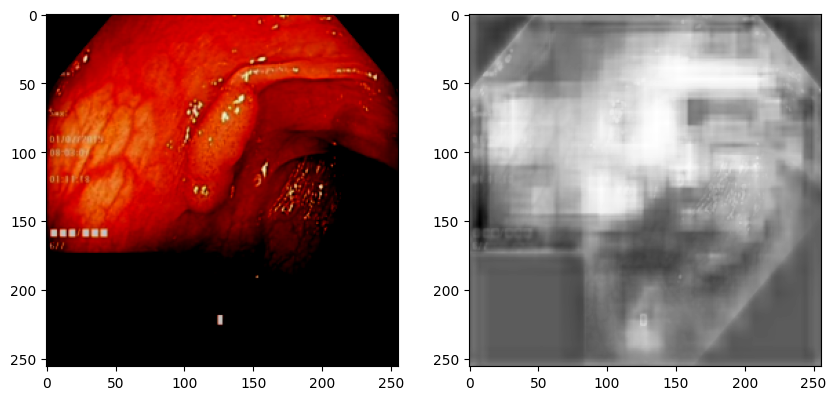

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


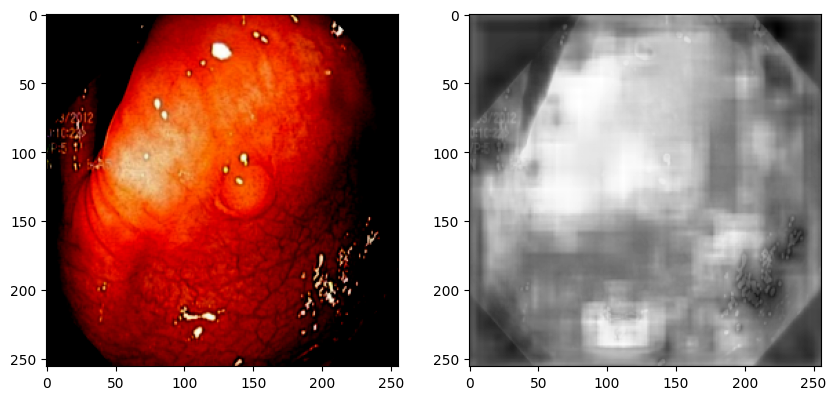

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


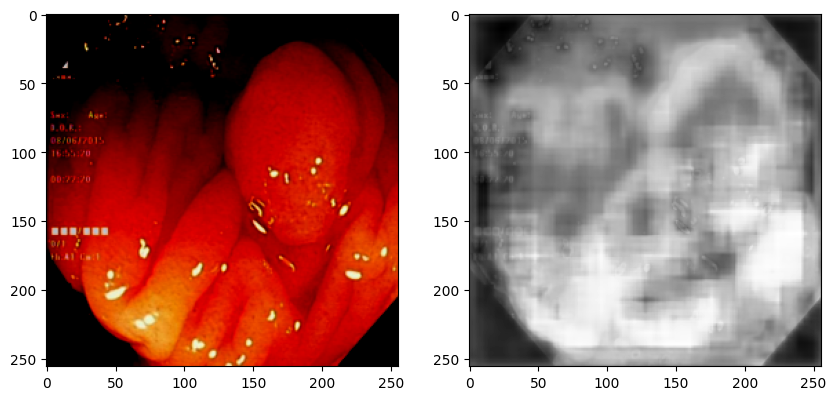

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


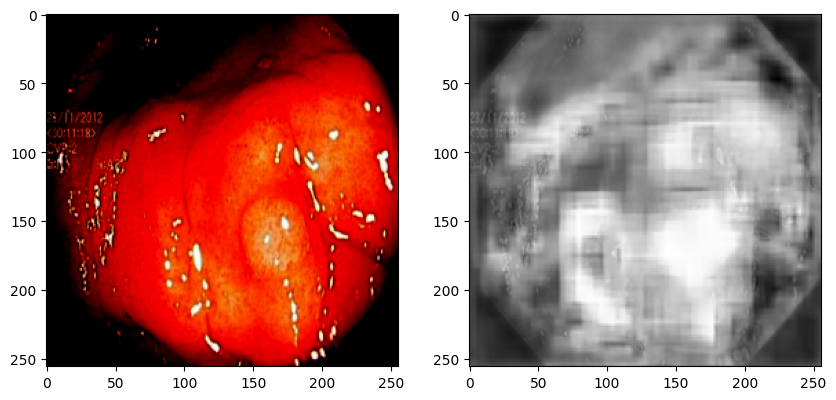

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


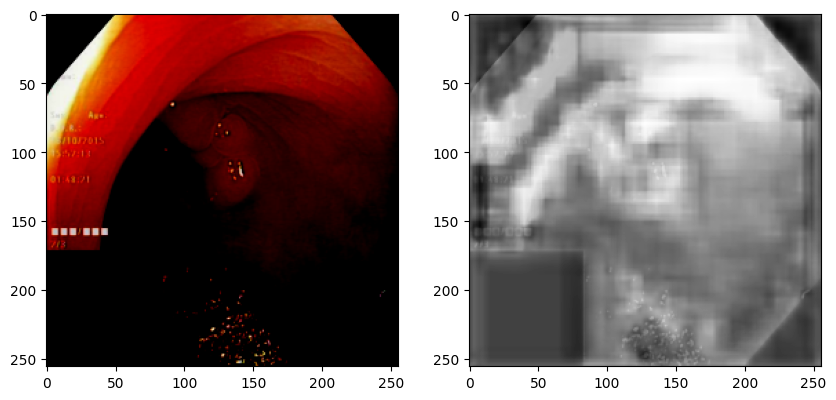

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


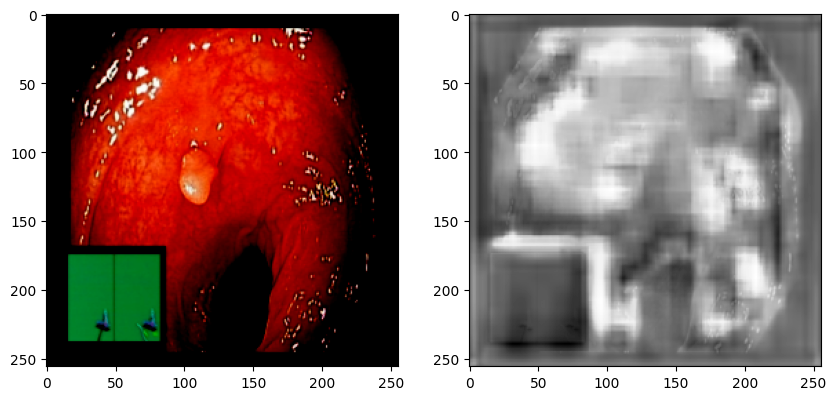

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


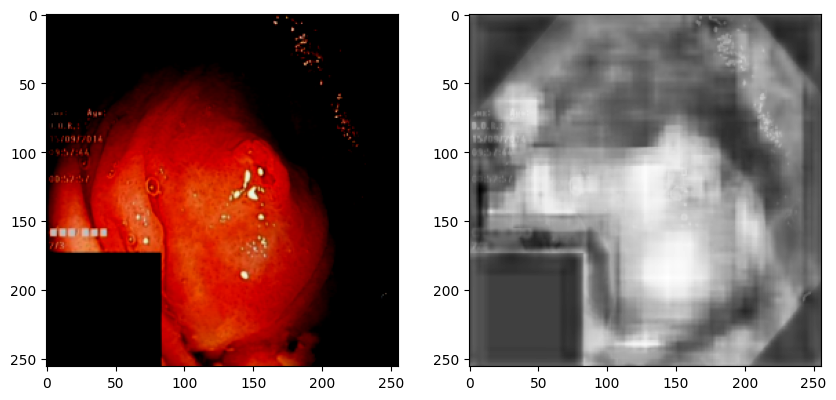

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


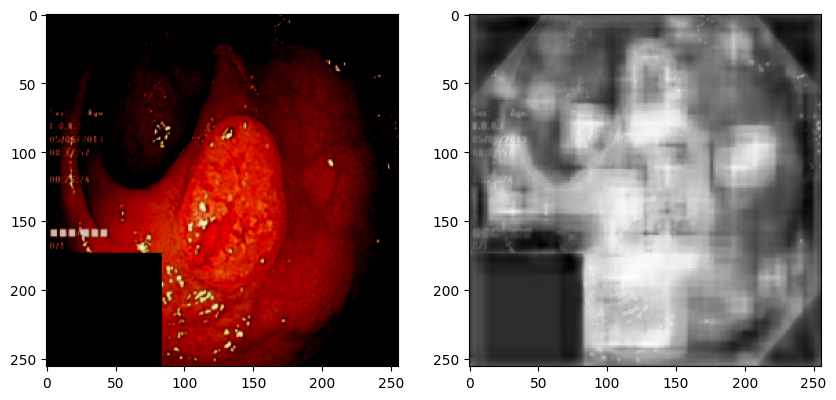

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


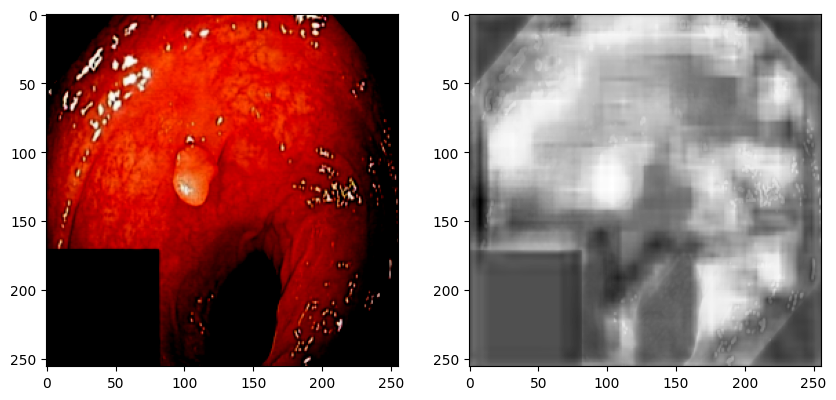

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


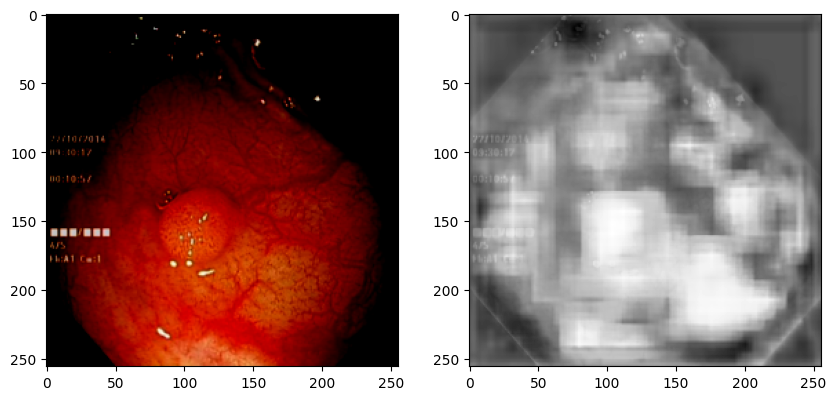

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


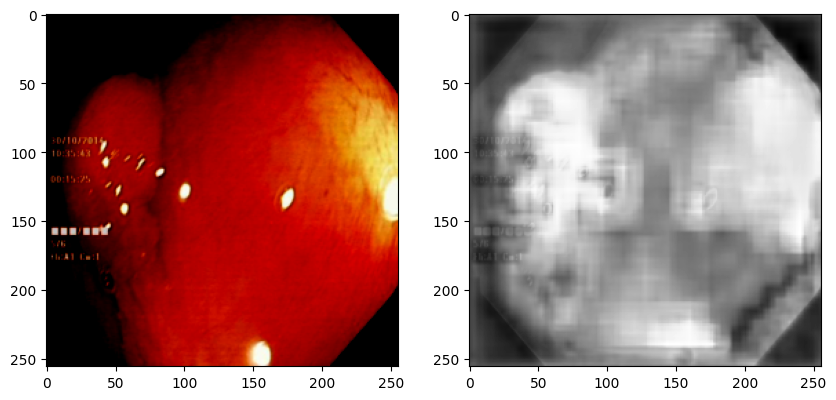

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


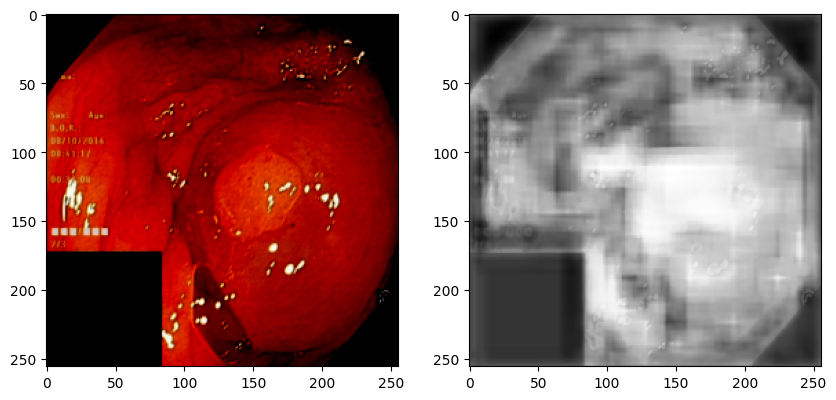

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


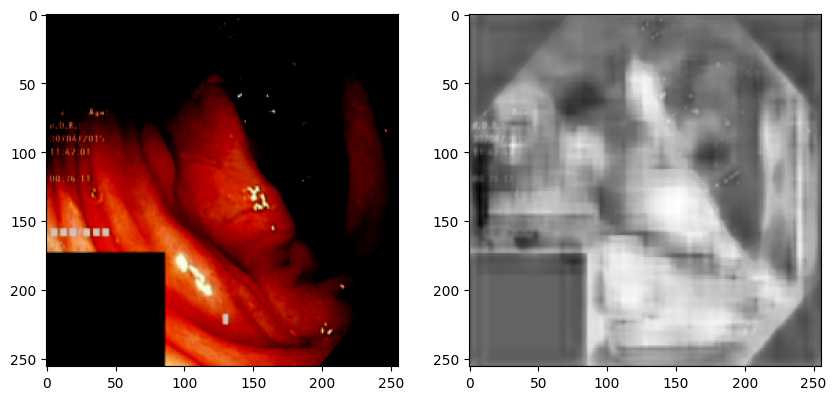

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


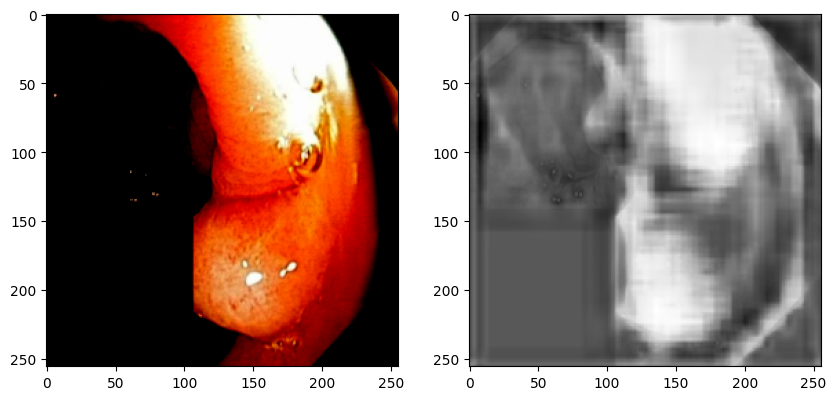

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


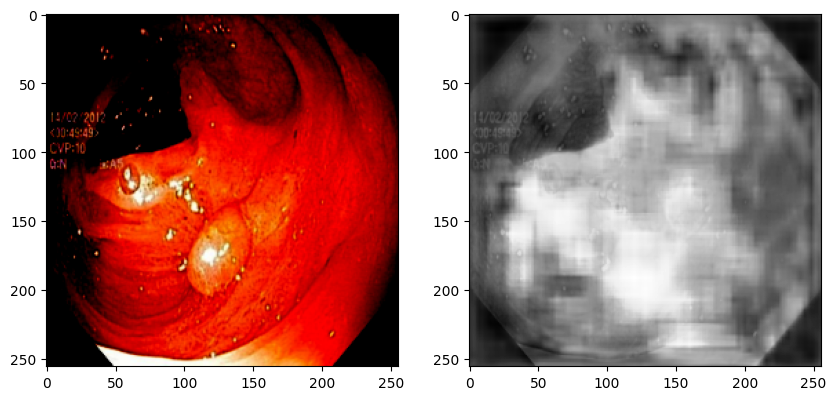

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


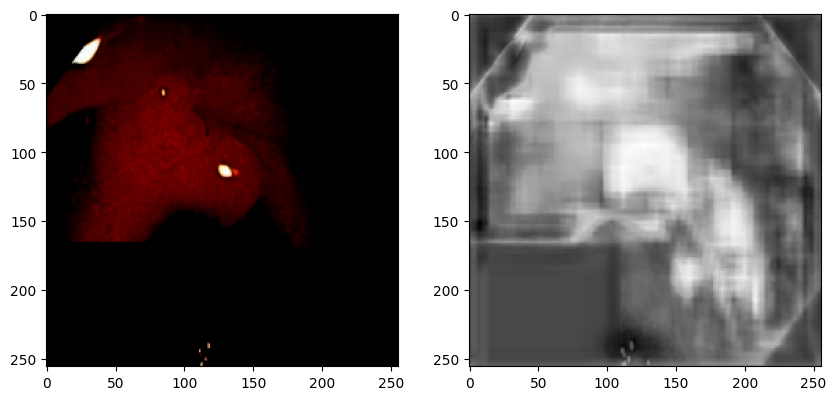

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


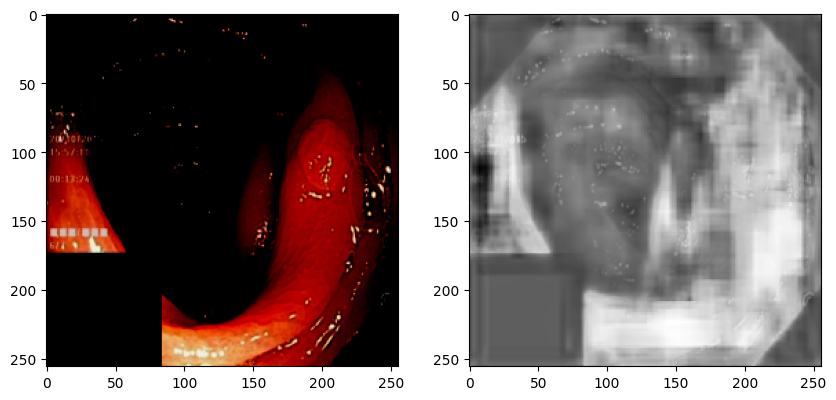

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


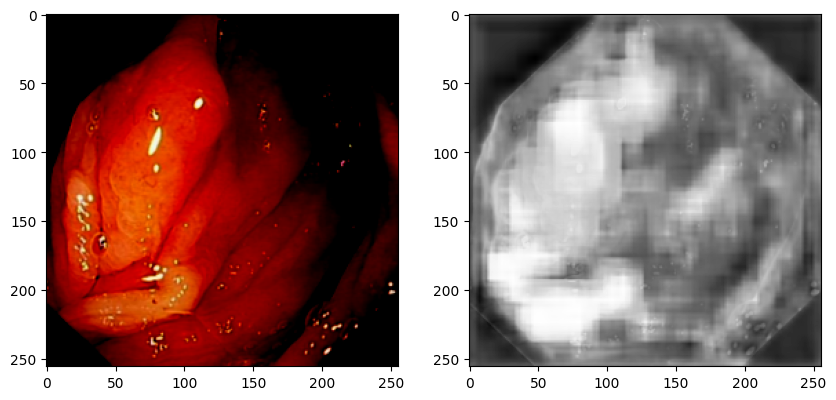

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


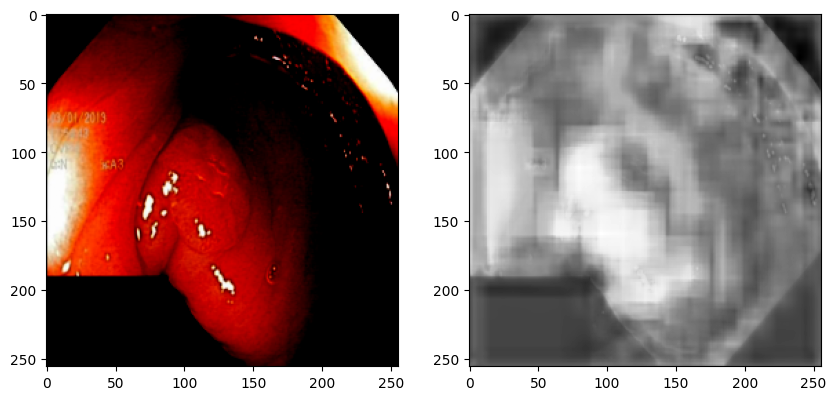

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


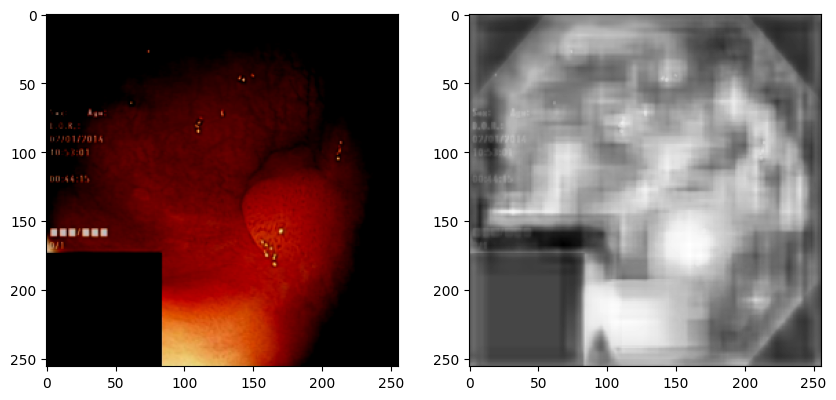

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


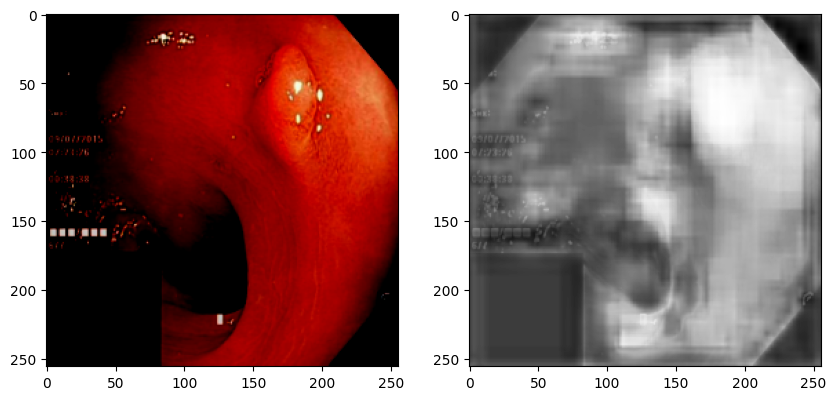

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


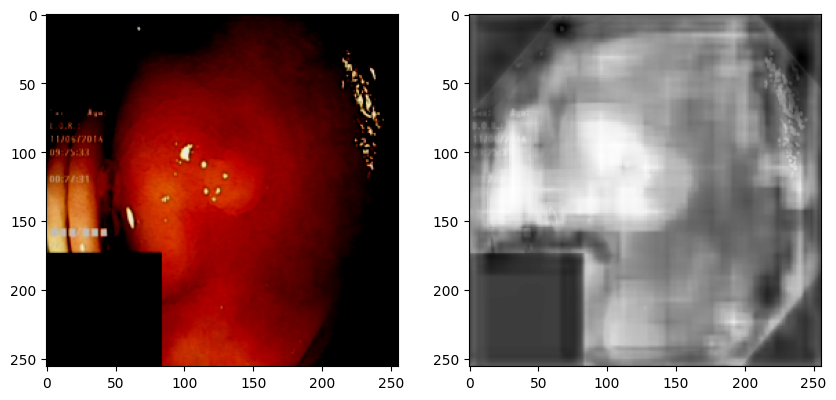

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


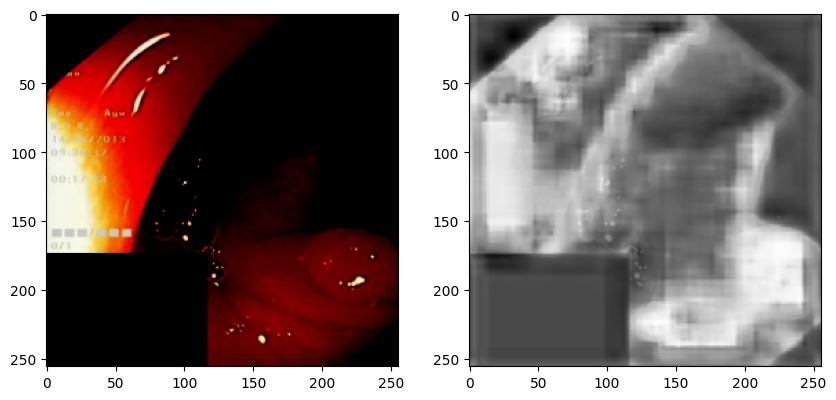

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


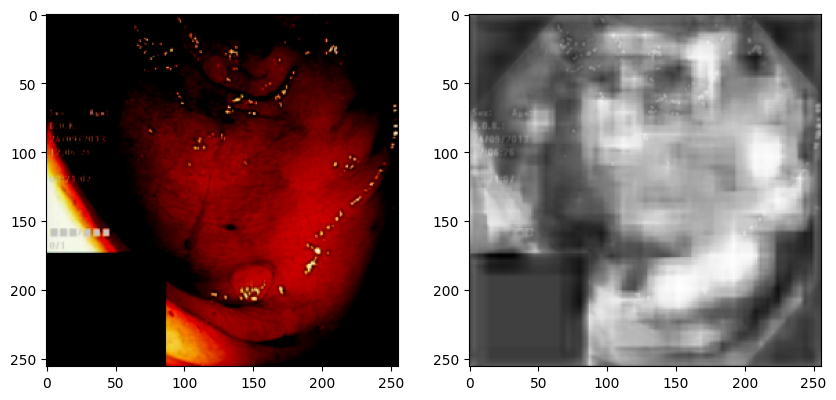

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


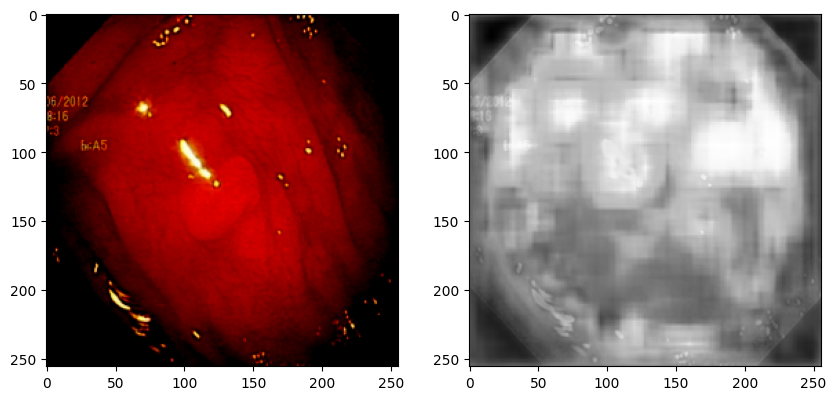

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


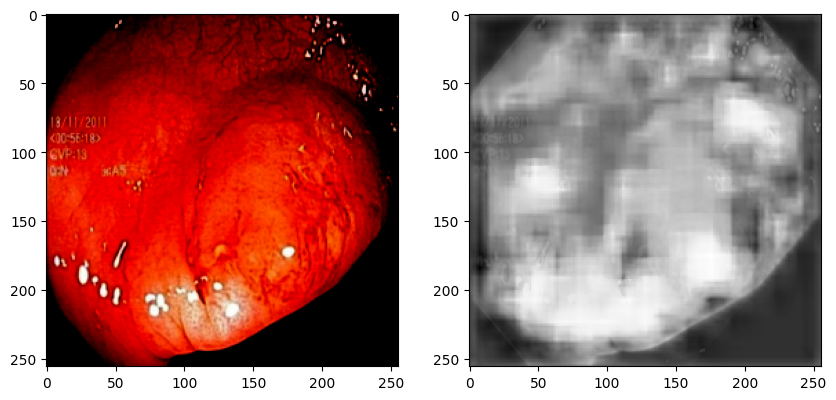

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


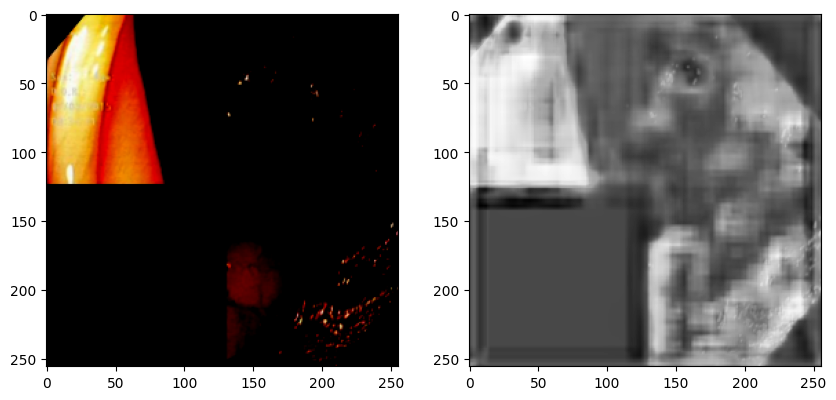

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


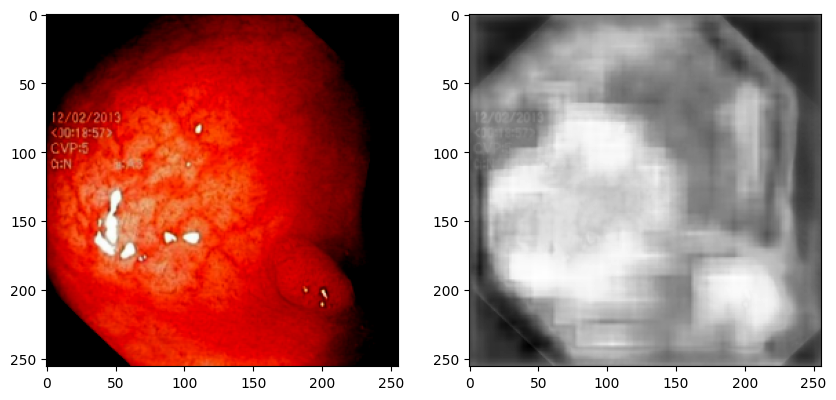

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


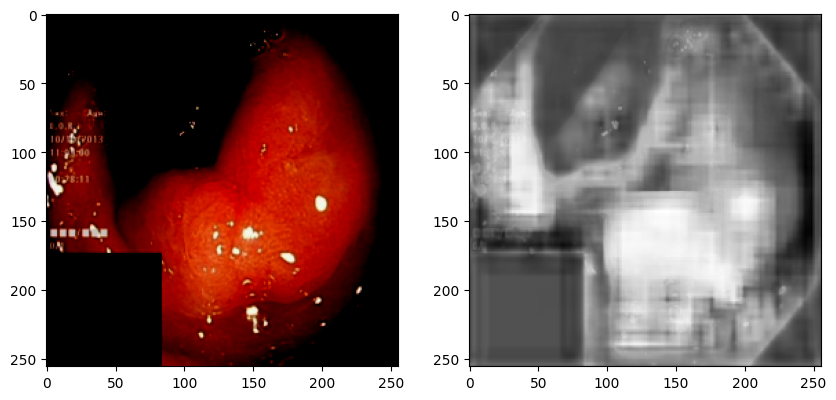

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


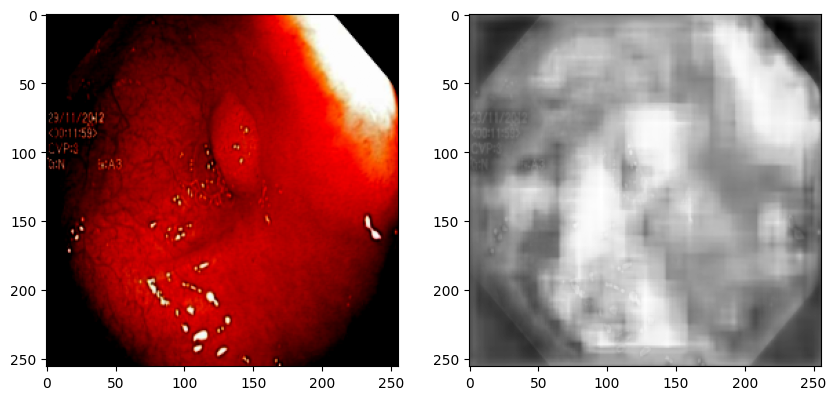

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


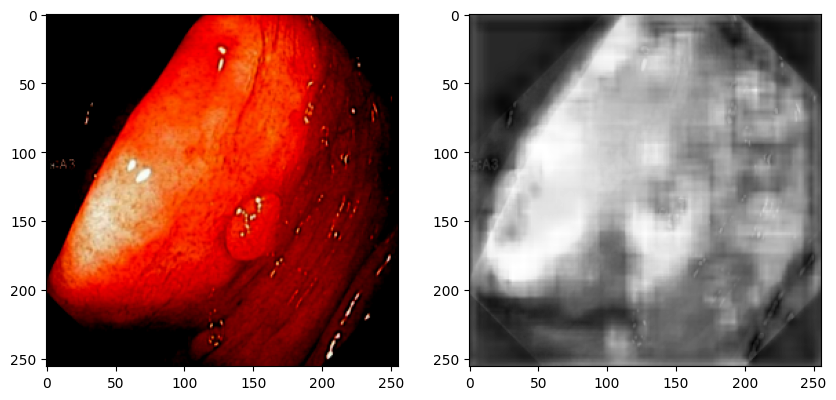

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


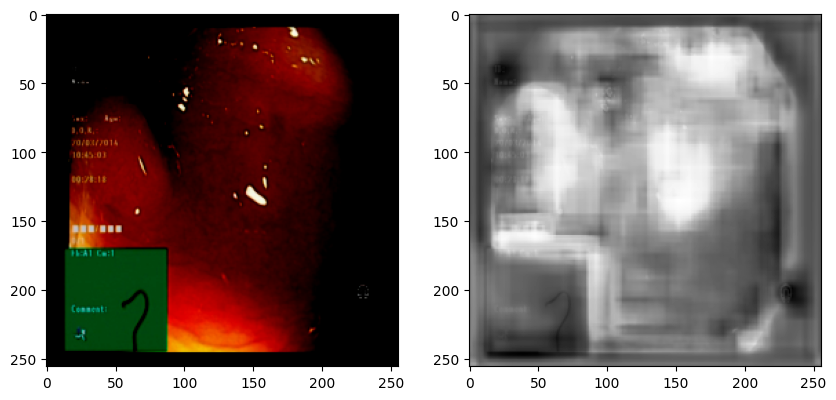

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


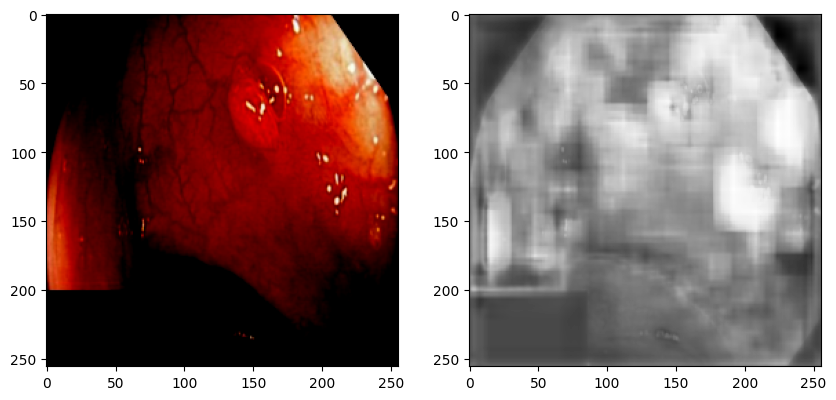

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


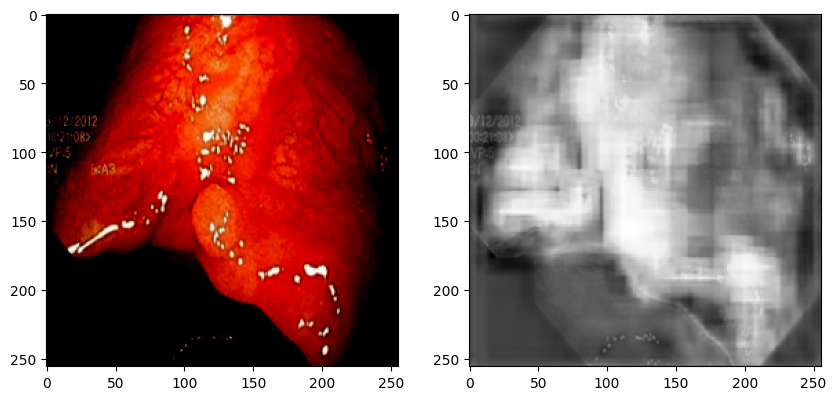

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


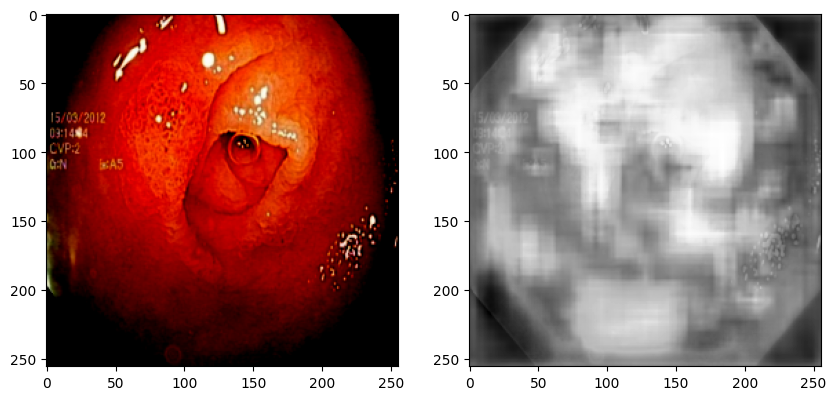

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


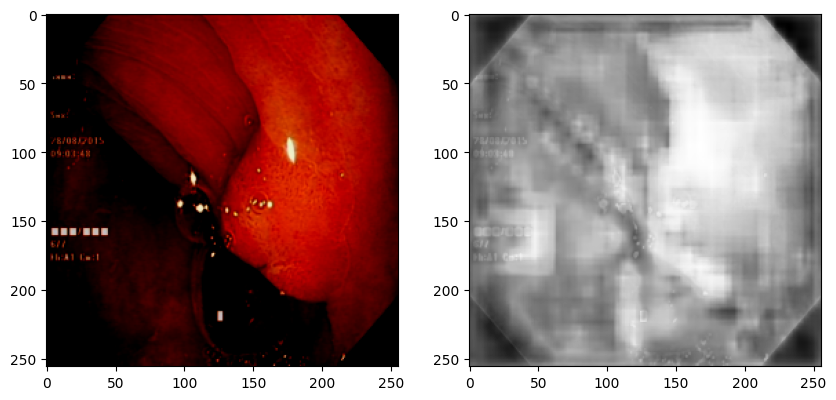

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


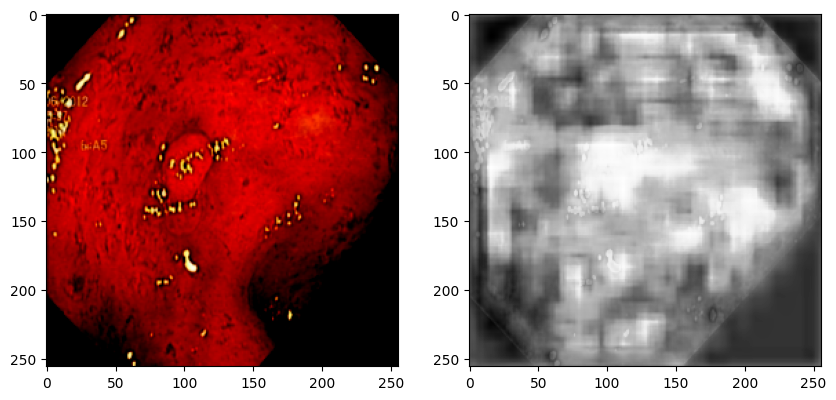

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


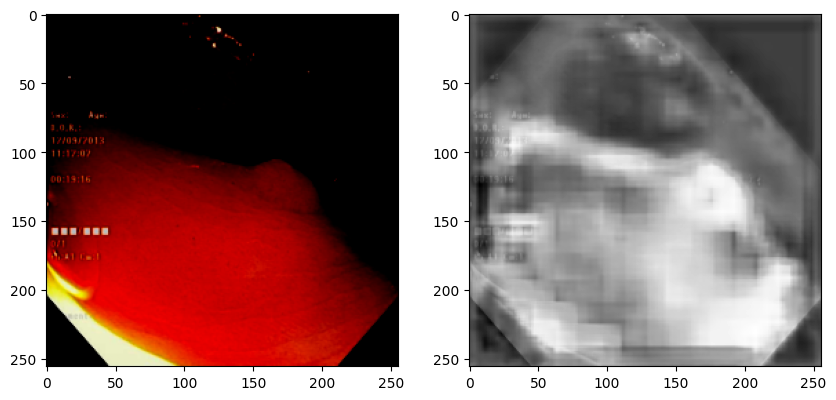

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


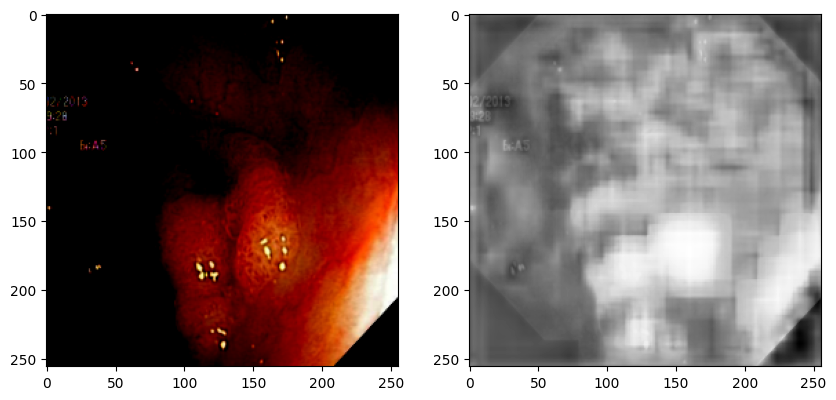

In [16]:
from glob import glob
for img, _ in test_dl:
    img = img.to(device)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show() 
    plt.close("all") 